# Similarity metrics between captions

## Loading

In [161]:
### Initialisation of the absolute Github repository path :
from pathlib import Path
import sys

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


### Import data prepared
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(f"Data preparation folder detected at: {DATA_PREPARATION_PY_PATH.resolve()}")

Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
Data preparation folder detected at: C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


### Imports:

In [ ]:
# Install Sentence Transformer for the semantic embedding purpose (Sentence-BERT (SBERT) model is used) :
# pip install -U sentence-transformers

In [ ]:
# Install Sentence Transformer for the semantic embedding purpose (Sentence-BERT (SBERT) model is used) :
# pip install -U sentence-transformers

# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle

# classic librairies
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# text processing librairies
import nltk
from collections import Counter
import re
from textblob import TextBlob
from sentence_transformers import SentenceTransformer, SimilarityFunction, util
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# statistical libraries
from statsmodels.stats import diagnostic
from scipy.stats import spearmanr, pearsonr
import networkx as nx

# clustering
from sklearn.cluster import KMeans
import umap


In [ ]:
# Download NLTK resources if not already
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

### Loading of preprocessed data's pickle :

In [ ]:
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

# Chargement du fichier pickle
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

# Extraction des objets stockés dans le pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']


## Semantic similarity, structure similarity

#### About the semantic embedding model used : 

Documentation : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/discussions/42#:~:text=These%20models%20are%20quite%20different,Tom%20Aarsen

The all-MiniLM-L6-v2 is a lightweight sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space (embeddings). It is designed for natural language understanding tasks like semantic search, clustering, and similarity comparisons, offering a balance of high performance and computational efficiency.

The model was trained using a self-supervised contrastive learning approach on over a billion sentence pairs, resulting in strong performance despite its relatively small size of 80 MB.

Key features:
- Lightweight: As a "Minimal Language Model," it is computationally efficient and requires less memory than larger models like BERT, making it suitable for resource-limited environments.
- Self-supervised training: It was trained without human-labeled data, using a contrastive learning objective to learn the relationships between similar and dissimilar sentence pairs.
- Large-scale fine-tuning: The model was fine-tuned on a vast dataset of over 1 billion sentence pairs from sources like Reddit, Wikipedia, and various question-answering datasets to improve its performance on downstream tasks.
- Versatile embeddings: It generates vector embeddings that capture the semantic meaning of text, which can be used for many NLP applications. 

Use cases :
- Sentence similarity: Calculates how similar in meaning two sentences are.
- Clustering: Groups similar texts together based on their embeddings.
- other


About 'contrastive learning':
- Contrastive learning trains a model by teaching it to distinguish similar and dissimilar data pairs, pulling representations of similar pairs (positive pairs) closer together and pushing dissimilar pairs (negative pairs) farther apart in a feature space.


Requirements:
*pip install -U sentence-transformers*

General documentation for Sentence_transformers SBERT models, to build from scratch a model : https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html#sentence_transformers.SentenceTransformer.similarity_pairwise

#### Training procedure:
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2#:~:text=deep%20learning%20frameworks.-,Intended%20uses,is%20above%201%20billion%20sentences.


Pre-training
We use the pretrained nreimers/MiniLM-L6-H384-uncased model (https://huggingface.co/nreimers/MiniLM-L6-H384-uncased) . Please refer to the model card for more detailed information about the pre-training procedure.

Fine-tuning
We fine-tune the model using a contrastive objective. Formally, we compute the cosine similarity from each possible sentence pairs from the batch. We then apply the cross entropy loss by comparing with true pairs.

Hyper parameters
We trained our model on a TPU v3-8. We train the model during 100k steps using a batch size of 1024 (128 per TPU core). We use a learning rate warm up of 500. The sequence length was limited to 128 tokens. We used the AdamW optimizer with a 2e-5 learning rate. The full training script is accessible in this current repository: train_script.py.

Training data
We use the concatenation from multiple datasets to fine-tune our model. The total number of sentence pairs is above 1 billion sentences. We sampled each dataset given a weighted probability which configuration is detailed in the data_config.json file.

In [ ]:
# Calculate semantic similarity :
def compute_semantic_similarity(df, text_col='caption', model_name='all-MiniLM-L6-v2'):

    model = SentenceTransformer(model_name, similarity_fn_name=SimilarityFunction.COSINE) #[SimilarityFunction.COSINE, SimilarityFunction.DOT_PRODUCT, SimilarityFunction.EUCLIDEAN, SimilarityFunction.MANHATTAN]
    
    embeddings = model.encode(df[text_col].tolist(), convert_to_tensor=True)
    
    semantic_sim = model.similarity(embeddings, embeddings) #cosine similarity scores for all possible pairs between embeddings1 and embeddings2.

    return semantic_sim



# Calculate structure similarity :
def extract_structure_features(text):
    text = str(text)
    words = re.findall(r"\b\w+\b", text)
    punct = re.findall(r"[^\w\s]", text)
    letters = re.findall(r"[A-Za-z]", text)
    digits = re.findall(r"\d", text)

    n_chars = len(text)
    n_words = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    punct_density = len(punct) / n_chars if n_chars > 0 else 0
    upper_letters_ratio = sum(1 for c in text if c.isupper()) / len(letters) if letters else 0
    digit_ratio = len(digits) / n_chars if n_chars > 0 else 0

    return [n_chars,
            n_words,
            avg_word_len,
            punct_density,
            upper_letters_ratio,
            digit_ratio]
        
def compute_structure_similarity(df, text_col='caption'):
    """
    Cosinus similarity based on:
    - Longueur du texte
    - Nombre de mots
    - Moyenne de longueur des mots
    - Densité de ponctuation
    - Ratio majuscules/minuscules
    - Ratio de chiffres
    """
    features = np.array([extract_structure_features(t) for t in df[text_col]])
    
    # Normalisation of the features: 
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Calcul de similarité cosinus
    structure_sim = cosine_similarity(features_scaled)
    return structure_sim





def compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio=0.5, structural_sim_ratio=0.5):
    combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim
    return combined_sim_matrix




# Similarity matrix
def plot_similarity_matrix(df, text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0.5, structural_sim_ratio=0.5, sample_size=None):
    """
    Calcule et visualise la matrice de similarité sémantique entre captions.
    
    captions : liste de phrases
    model_name : modèle SBERT à utiliser
    sample_size : nombre de captions à afficher (pour éviter une matrice trop grande)
    """

    # Échantillonnage si nécessaire
    if sample_size!=None and len(df) > sample_size:
        df = df.sample(sample_size, random_state=42).reset_index(drop=True)
        #        df = df.head(sample_size).reset_index(drop=True)

    captions = df[text_col].tolist()
    
    semantic_sim = compute_semantic_similarity(df, text_col=text_col, model_name=model_name)
    structural_sim = compute_structure_similarity(df, text_col=text_col)
    sim_matrix = compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio, structural_sim_ratio)

    df_sim = pd.DataFrame(sim_matrix, index=captions, columns=captions)

    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sim, cmap="coolwarm", xticklabels=True, yticklabels=True, annot=True, fmt=".2f", linewidths=.5)
    plt.title("Matrice de similarité sémantique (SBERT)")
    plt.show()
    
    return df_sim





def cluster_captions_kmeans_umap(
    df,
    text_col='caption',
    model_name='all-MiniLM-L6-v2',
    n_clusters=5,
    random_state=42,
    normalize=True,
    umap_n_neighbors=15,
    umap_min_dist=0.1,
    umap_metric='cosine'
):
    """
    Clustering KMeans + Visualisation UMAP des captions selon leurs embeddings SBERT.

    Paramètres :
    -----------
    df : pd.DataFrame
        DataFrame contenant les captions.
    text_col : str
        Colonne contenant les textes.
    model_name : str
        Modèle SentenceTransformer à utiliser.
    n_clusters : int
        Nombre de clusters pour KMeans.
    random_state : int
        Graine aléatoire.
    normalize : bool
        Si True, standardise les embeddings avant KMeans et UMAP.
    umap_n_neighbors : int
        Nombre de voisins pour UMAP (affecte la granularité locale).
    umap_min_dist : float
        Distance minimale entre points dans l’espace UMAP.
    umap_metric : str
        Métrique de distance pour UMAP (souvent 'cosine' pour embeddings).

    Retour :
    --------
    df_clusters : DataFrame avec colonnes ['caption', 'cluster', 'umap_x', 'umap_y']
    """

    # Encodage SBERT
    print(f"[INFO] Encodage SBERT avec le modèle '{model_name}' ...")
    model = SentenceTransformer(model_name)
    embeddings = model.encode(df[text_col].tolist(), convert_to_numpy=True, show_progress_bar=True)

    # Normalisation
    if normalize:
        embeddings = StandardScaler().fit_transform(embeddings)

    # KMeans
    print(f"[INFO] Clustering KMeans avec {n_clusters} clusters ...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    # UMAP projection
    print("[INFO] Réduction de dimension avec UMAP (2D) ...")
    reducer = umap.UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        metric=umap_metric,
        random_state=random_state
    )
    umap_embeddings = reducer.fit_transform(embeddings)

    # Construction du DataFrame final
    df_clusters = df.copy()
    df_clusters['cluster'] = cluster_labels
    df_clusters['umap_x'] = umap_embeddings[:, 0]
    df_clusters['umap_y'] = umap_embeddings[:, 1]

    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_clusters,
        x='umap_x',
        y='umap_y',
        hue='cluster',
        palette='tab10',
        s=70,
        alpha=0.8,
        edgecolor='white'
    )
    plt.title(f"Visualisation UMAP des clusters SBERT (KMeans, k={n_clusters})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("[INFO] Visualisation terminée ✅")

    return df_clusters, embeddings






# Humour similarity
def analyze_humor_similarity(df, text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=None):
    """
    Analyse la relation entre similarité sémantique et score d’humour.
    
    - Calcule toutes les paires de captions
    - Compare leur similarité sémantique (SBERT)
    - Compare leur écart de score d’humour
    - Calcule la corrélation entre les deux
    """

    # Échantillonnage si nécessaire
    if sample_size!=None and len(df) > sample_size:
        df = df.head(sample_size).reset_index(drop=True)
    #    df = df.sample(sample_size, random_state=42).reset_index(drop=True)


    semantic_sim = compute_semantic_similarity(df, text_col=text_col, model_name=model_name)
    structural_sim = compute_structure_similarity(df, text_col=text_col)
    sim_matrix = compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio, structural_sim_ratio)
    
    # Extraire les valeurs de similarité et de différence de score d’humour
    sims = []
    humor_diffs = []
    scores = df[humor_col].to_numpy()
    n = len(scores)
    
    for i in range(n):
        for j in range(i+1, n):
            sims.append(sim_matrix[i, j])
            humor_diffs.append(abs(scores[i] - scores[j]))
    
    sims = np.array(sims)
    humor_diffs = np.array(humor_diffs)
    
    # Corrélation entre similarité et écart d’humour
    corr_spearman, _ = spearmanr(sims, -humor_diffs)
    corr_pearson, _ = pearsonr(sims, -humor_diffs)
    
    # Visualisation
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=sims, y=-humor_diffs, alpha=0.5)
    plt.xlabel("Similarité sémantique")
    plt.ylabel("Proximité du score d’humour (inverse de l’écart)")
    plt.title(f"Corrélation humour/similarité\nSpearman = {corr_spearman:.2f}, Pearson = {corr_pearson:.2f}")
    plt.show()
    
    return {
        'spearman': corr_spearman,
        'pearson': corr_spearman
    }



C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\2959620224.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


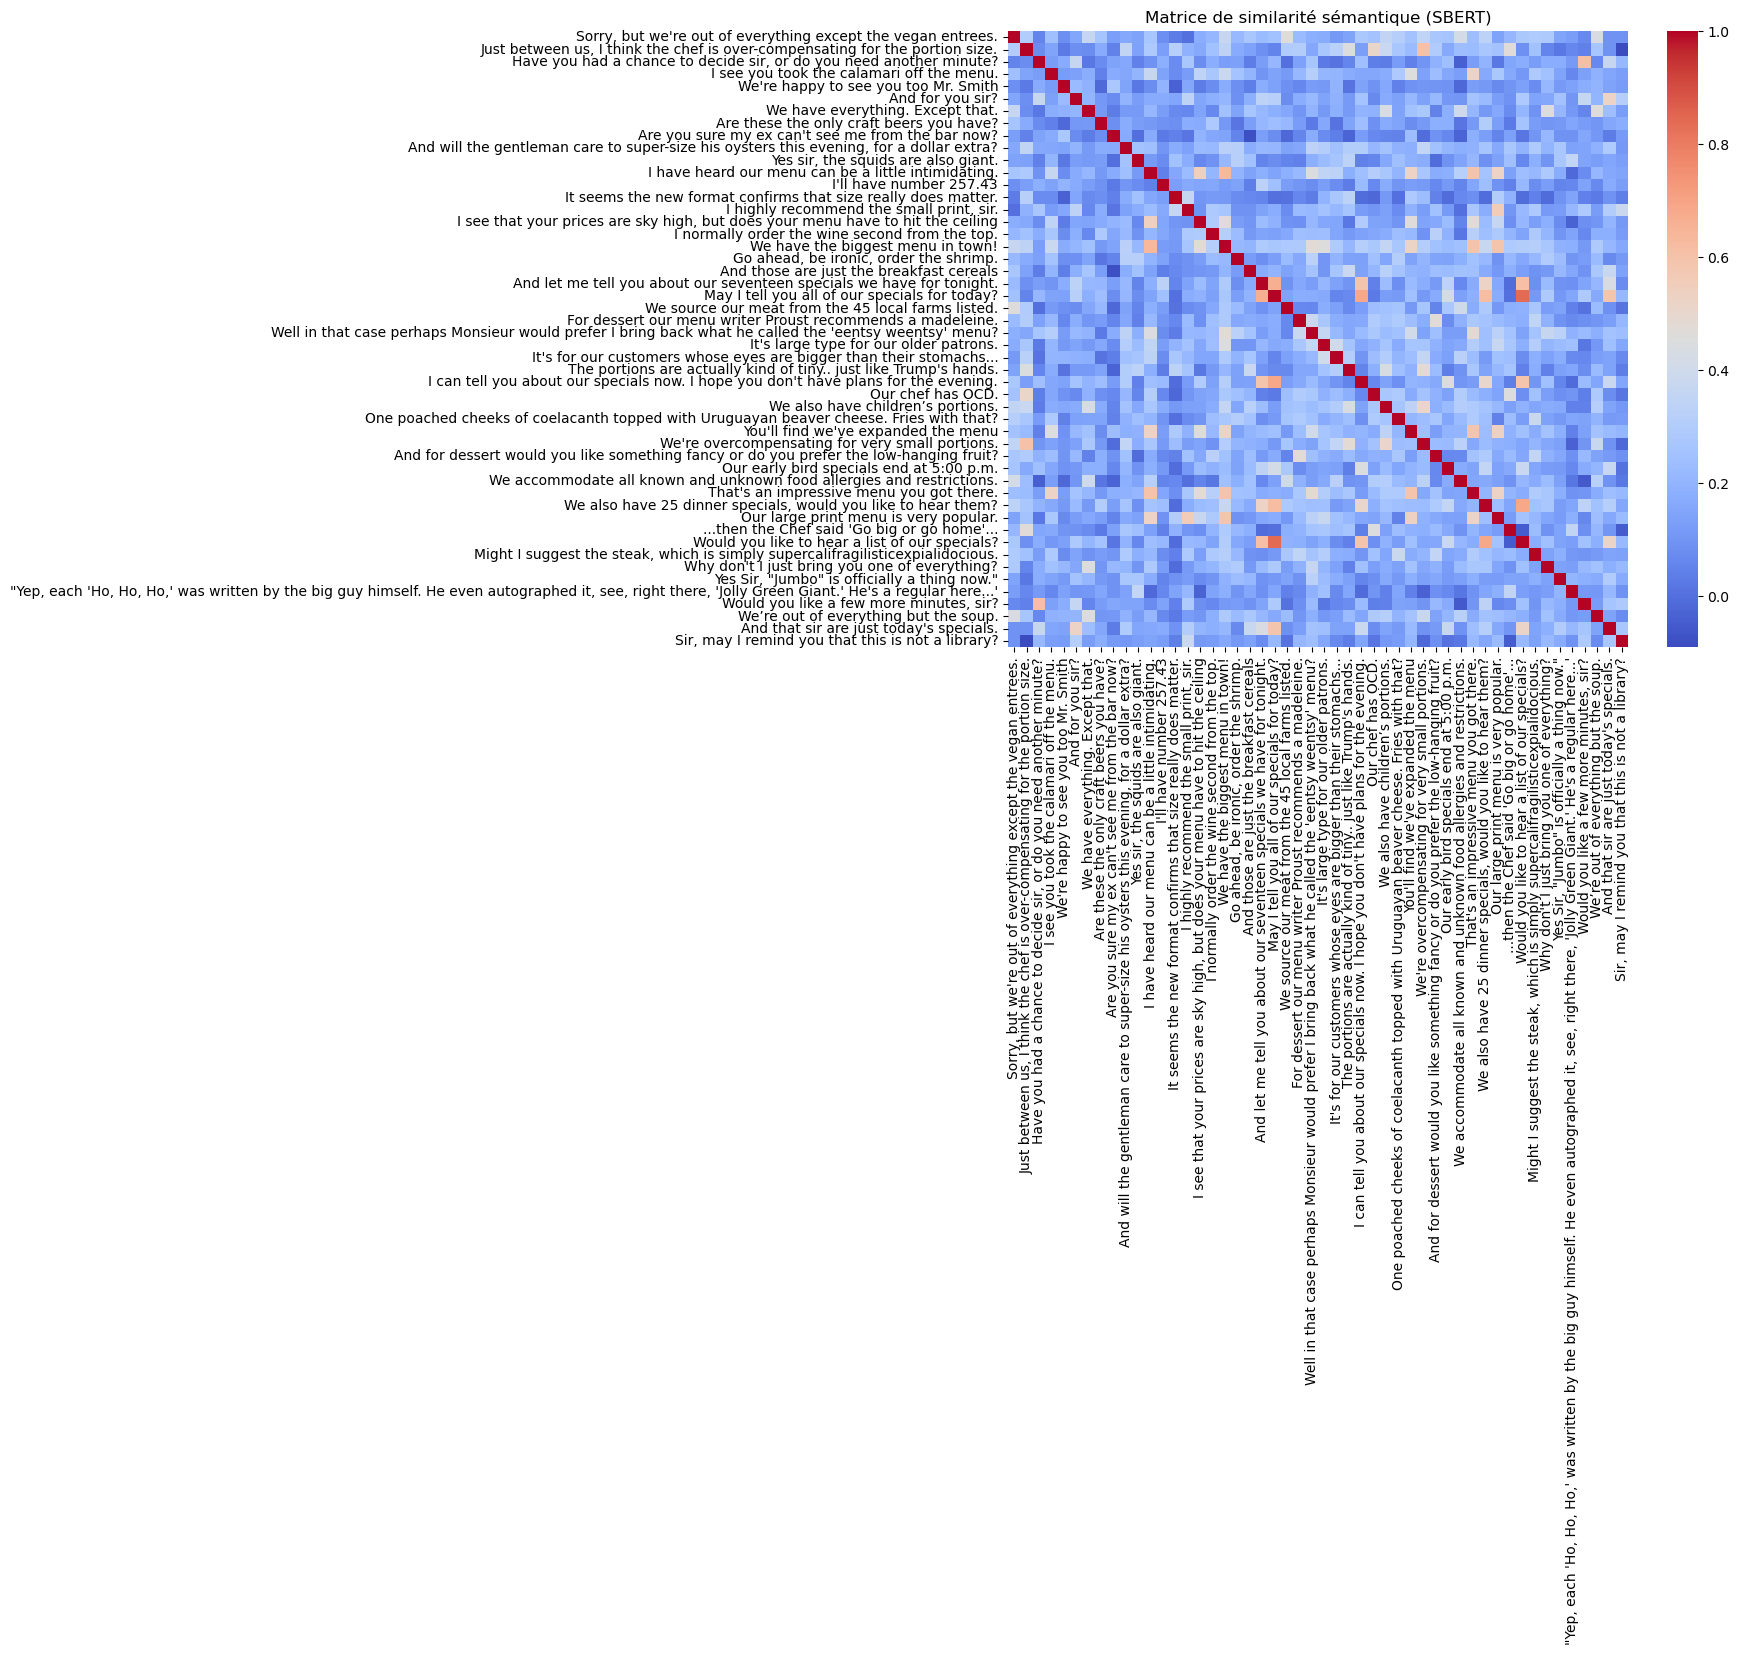

In [10]:
df_sim1 = plot_similarity_matrix(dataA[77], text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=1, structural_sim_ratio=0, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\2959620224.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


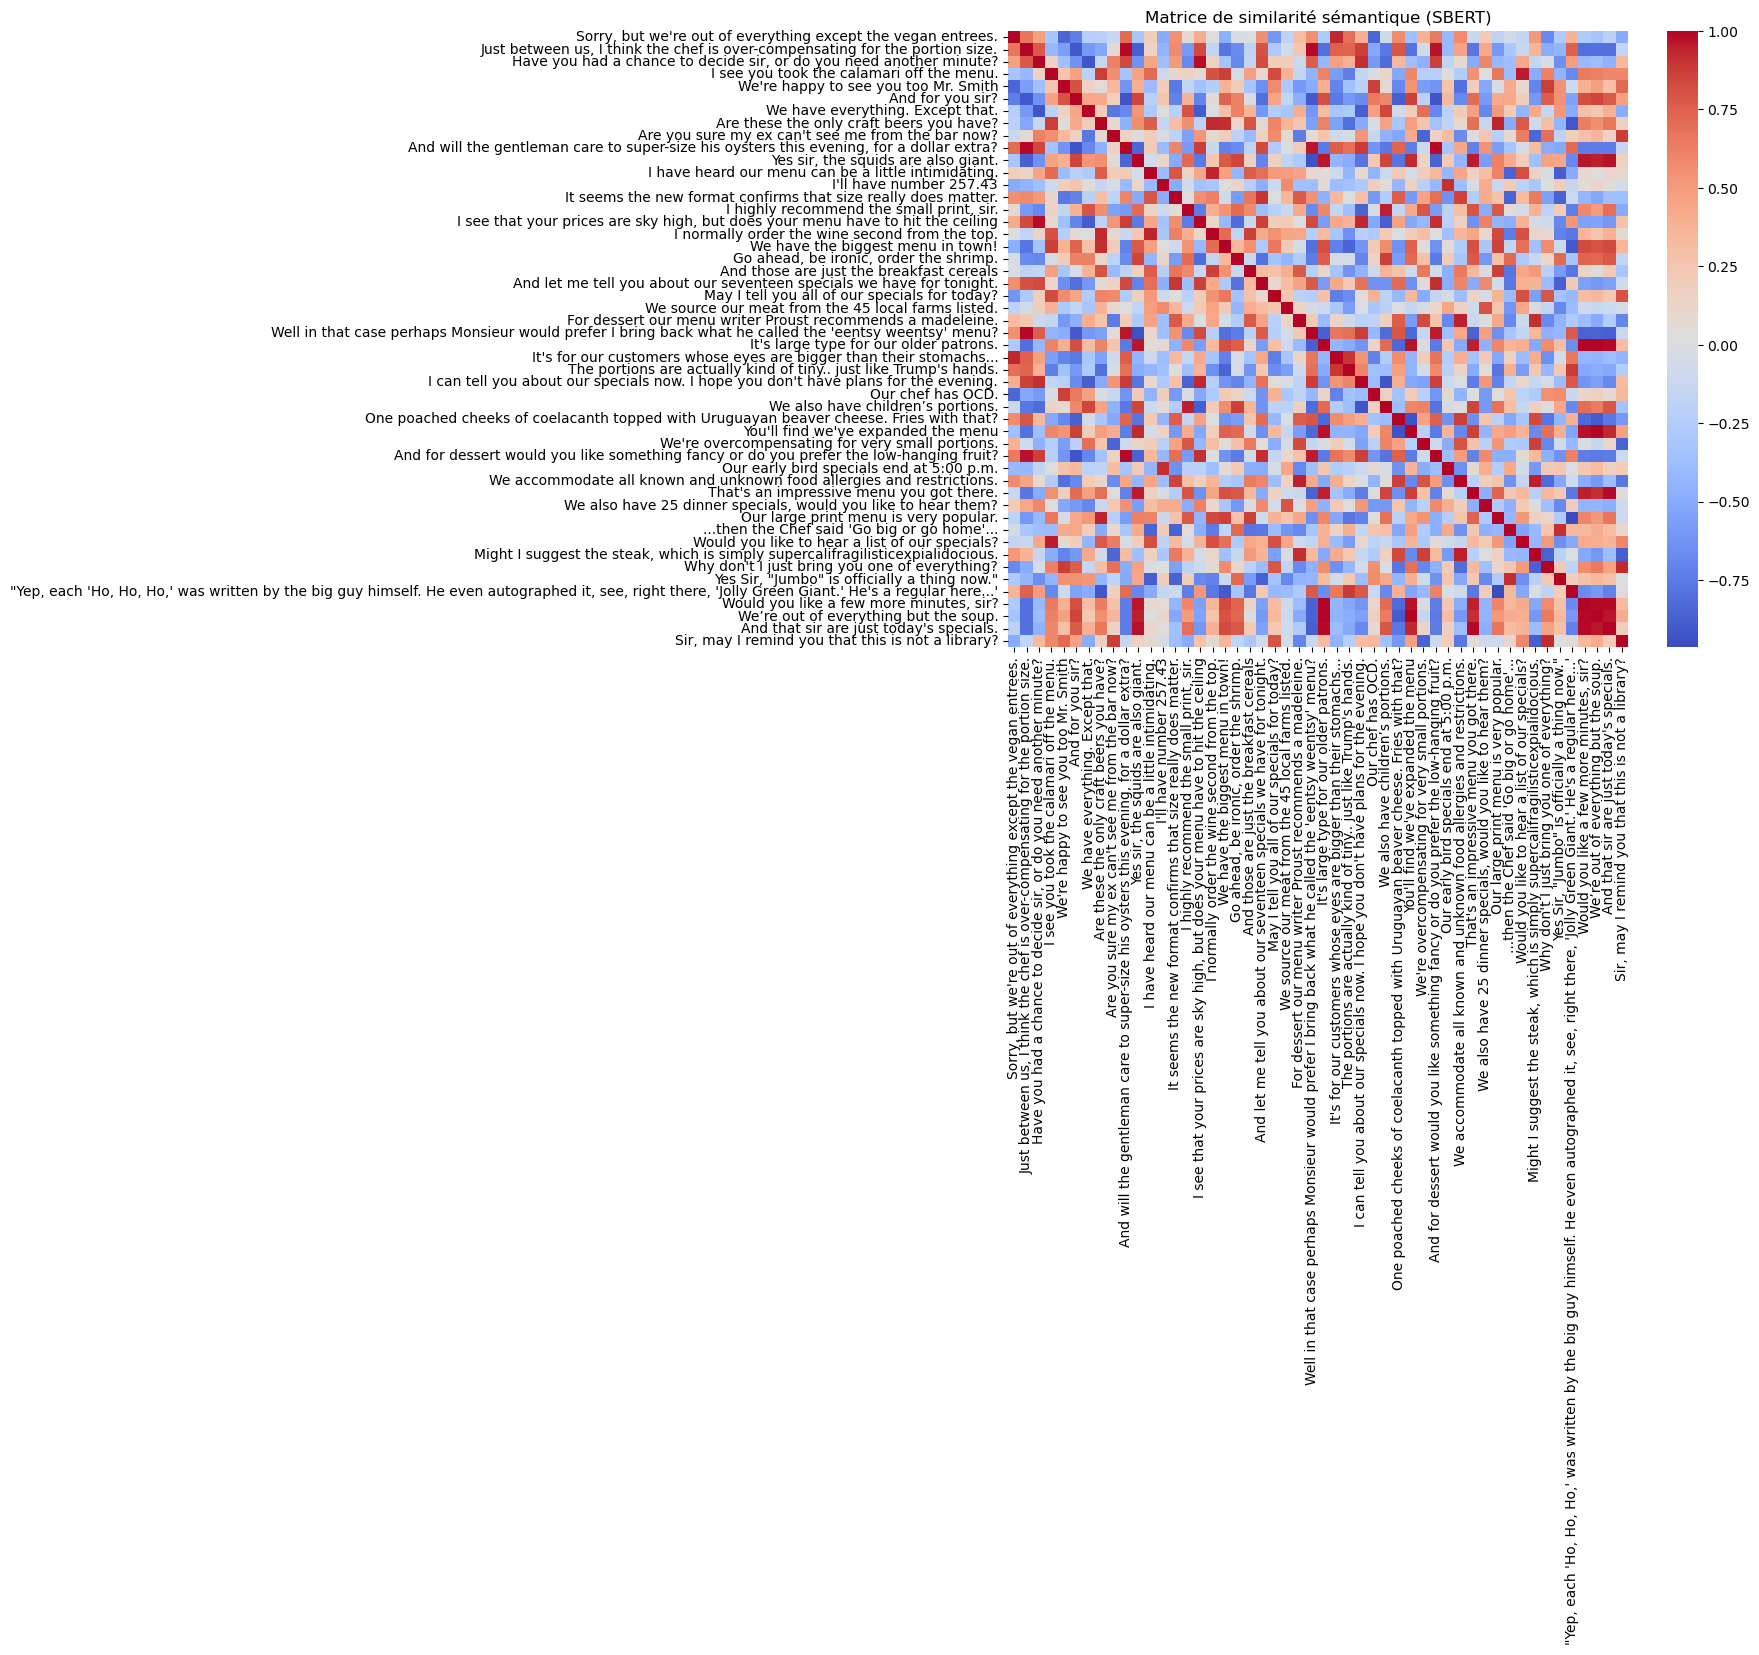

In [11]:
df_sim2 = plot_similarity_matrix(dataA[77], text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\2959620224.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


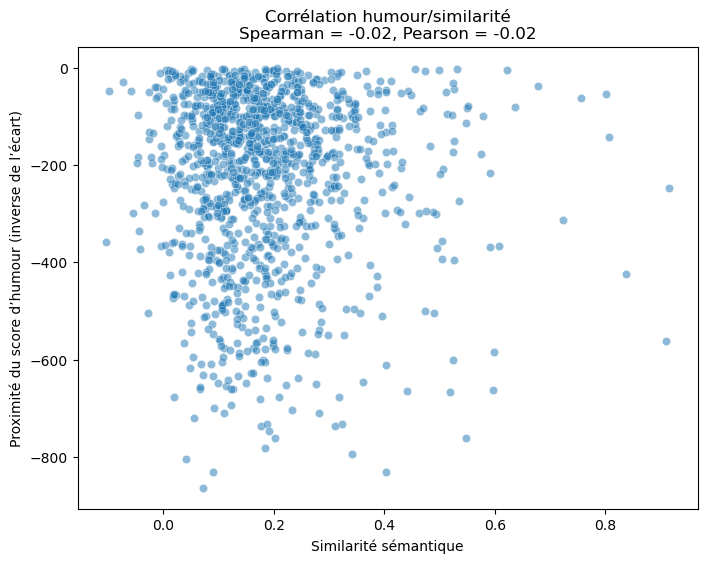

In [12]:
corr_spearman1, corr_spearman1 = analyze_humor_similarity(dataA[77], text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=1, structural_sim_ratio=0, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\2959620224.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


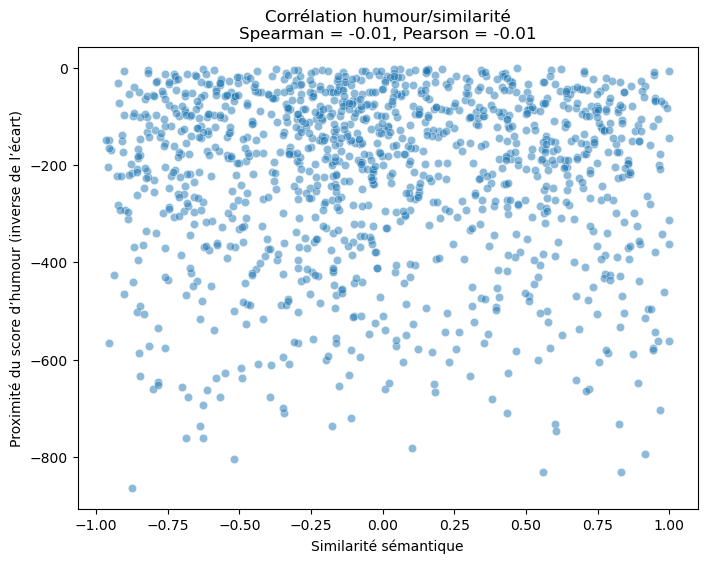

In [13]:
corr_spearman2, corr_spearman2 = analyze_humor_similarity(dataA[77], text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=50)

Plusieurs bandes horizontales --> cela vient du fait que les scores d’humour sont discrets (ex. 0–5), donc certaines valeurs de -humor_diffs sont répétées\

Une forte densité en haut (proximité de 0) --> beaucoup de paires ont des scores d’humour très proches indépendement leur niveau de similarité.

In [14]:
# comme je prend un échantillon aléatoire de caption, qui sont à la base ordonnées par rang de la meilleure caption (la plus drole) à la moins bonne caption, est ce qu'il ne faudrait mieux pas prendre des echantillons ordonnés ?
# Deuxième question, comment est il possible de procéder à cette analyse dans le but de clusteuriser des groupes de captions ? exemple : je veux analyser l'humour des captions au sein de clusters qui évoquent des axes de stratégies de blagues similaires

#### Des tests !

C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\125813130.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


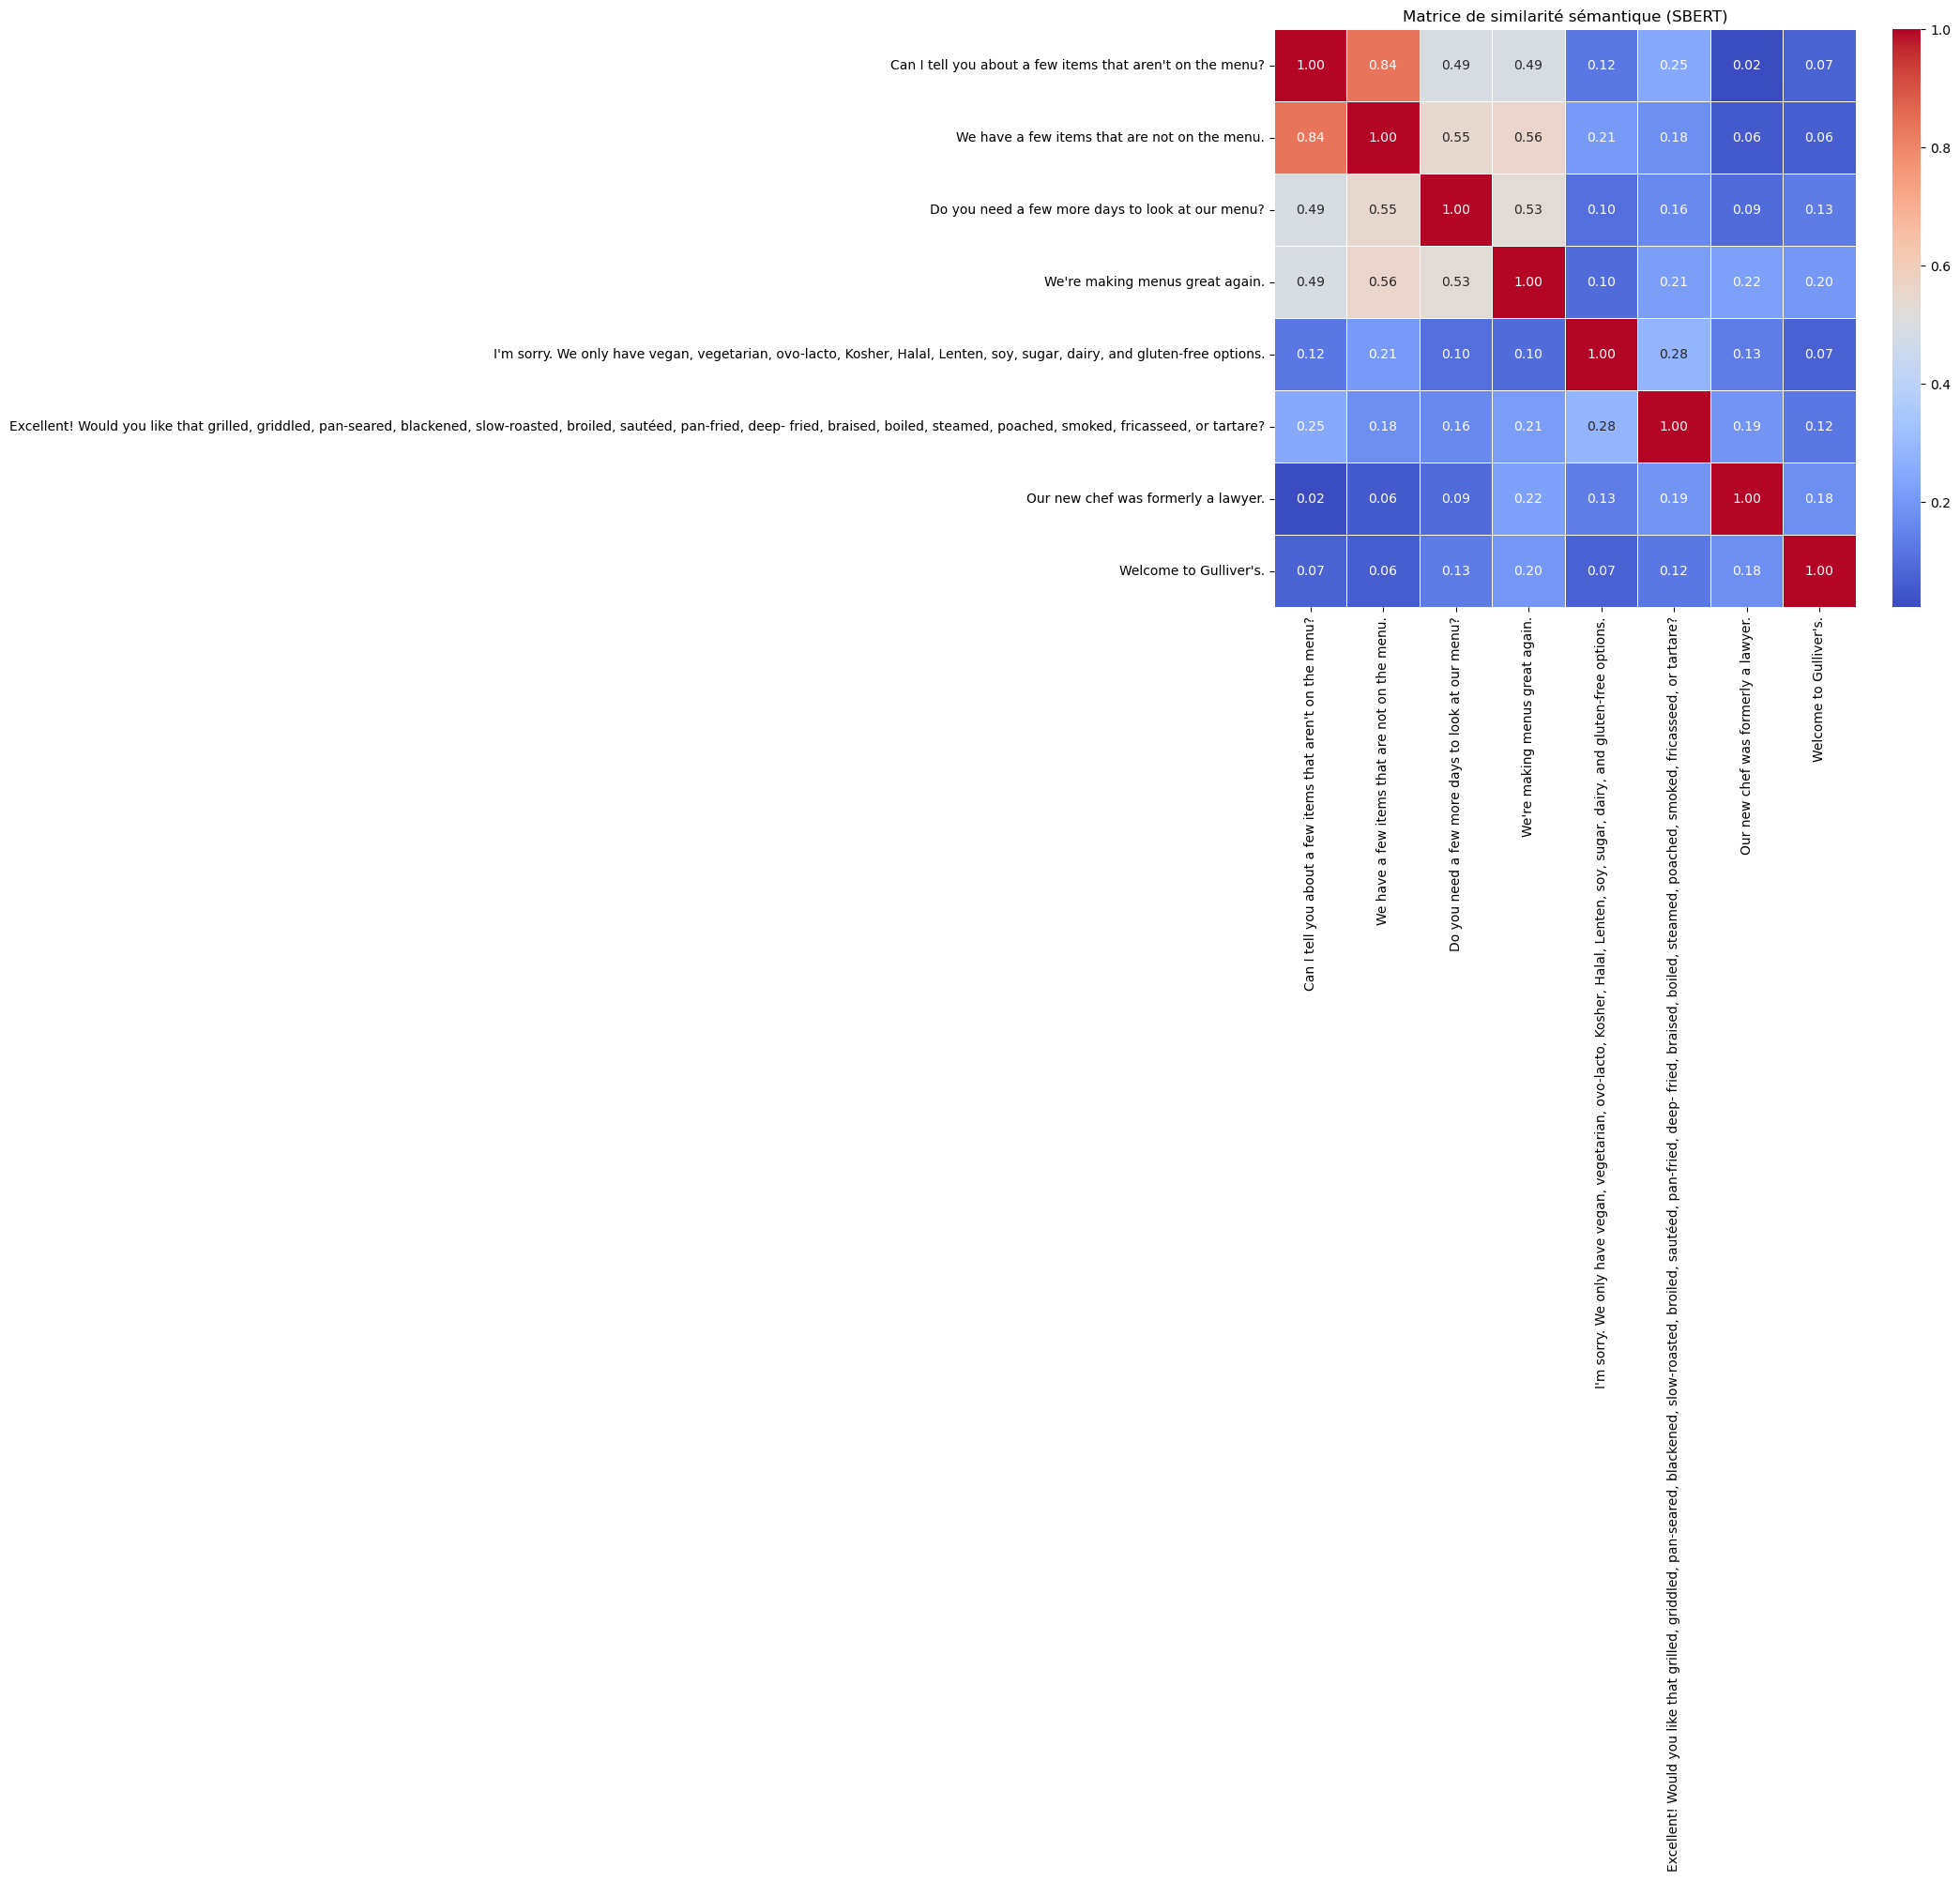

In [32]:
# model_name : ["all-MiniLM-L6-v2", "paraphrase-MiniLM-L12-v2", "all-mpnet-base-v2"]


# Encode some texts
sentences = [
    "Can I tell you about a few items that aren't on the menu?",
    "We have a few items that are not on the menu.",
    "Do you need a few more days to look at our menu?",
    "We're making menus great again.",
    "I'm sorry. We only have vegan, vegetarian, ovo-lacto, Kosher, Halal, Lenten, soy, sugar, dairy, and gluten-free options.",
    "Excellent! Would you like that grilled, griddled, pan-seared, blackened, slow-roasted, broiled, sautéed, pan-fried, deep- fried, braised, boiled, steamed, poached, smoked, fricasseed, or tartare?",
    "Our new chef was formerly a lawyer.",
    "Welcome to Gulliver's.",
]
sentences_test_df = pd.DataFrame()
sentences_test_df["caption"] = sentences

df_sim3 = plot_similarity_matrix(sentences_test_df, text_col='caption', model_name="all-MiniLM-L6-v2", semantic_sim_ratio=1, structural_sim_ratio=0)


C:\Users\cyrie\AppData\Local\Temp\ipykernel_18564\125813130.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


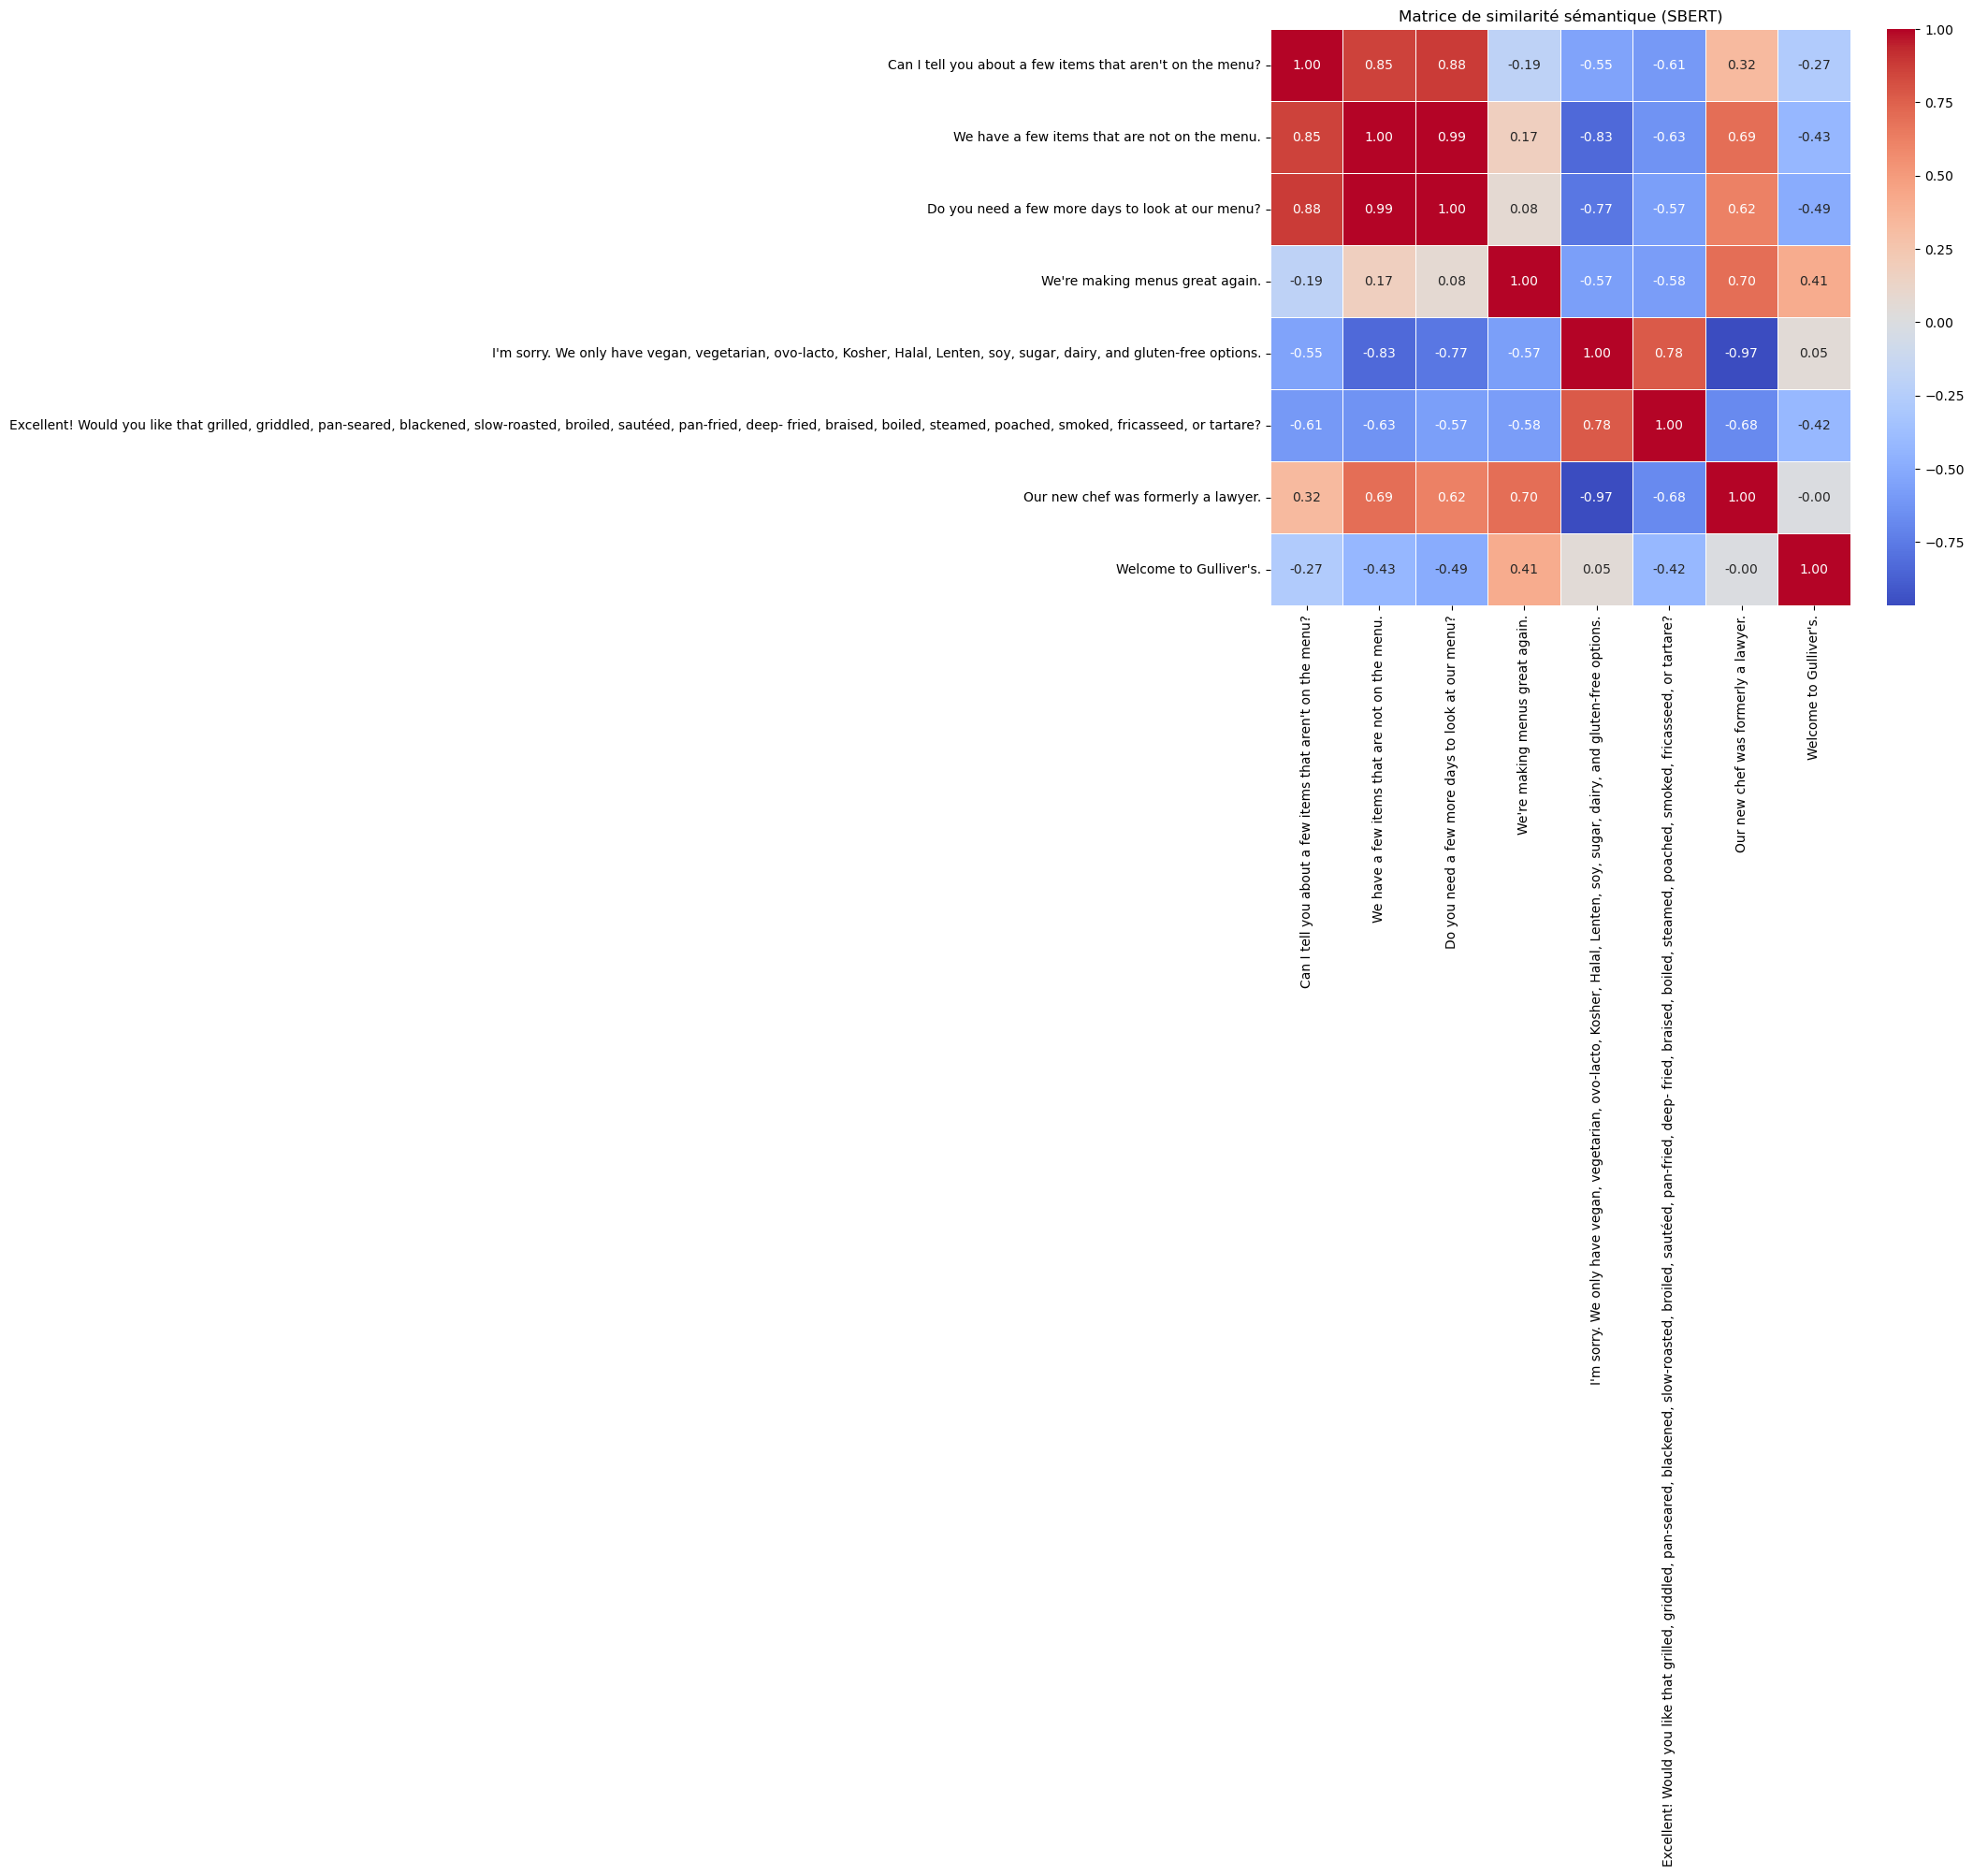

In [33]:
df_sim3 = plot_similarity_matrix(sentences_test_df, text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1)


[INFO] Encodage SBERT avec le modèle 'all-MiniLM-L6-v2' ...


Batches: 100%|██████████| 191/191 [01:13<00:00,  2.59it/s]


[INFO] Clustering KMeans avec 5 clusters ...
[INFO] Réduction de dimension avec UMAP (2D) ...


c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


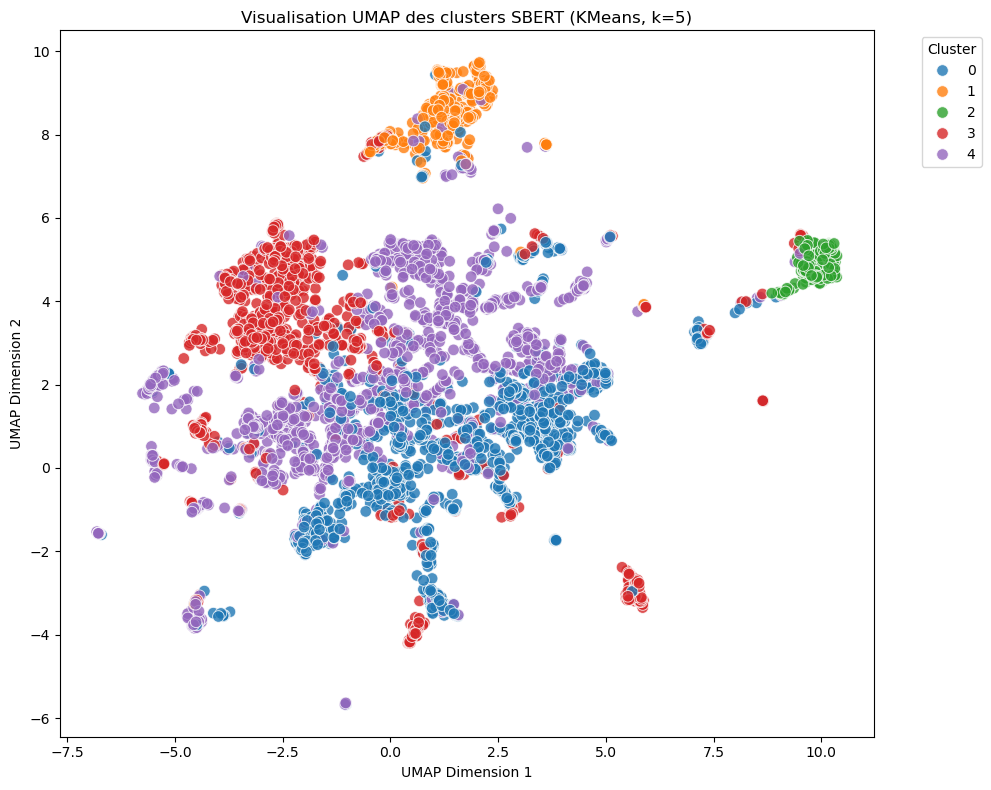

[INFO] Visualisation terminée ✅


In [20]:
df_sim4, embeddings_results_test = cluster_captions_kmeans_umap(dataA[77])

In [ ]:
# !!!!
# Developers should also consider how much variance is retained during UMAP.
# If 95% of the variance is preserved after reducing dimensions, the trade-off
# between simplicity and information loss might be acceptable.
# !!!

## Similarity metrics of the paper:

\url[file:///C:/Users/cyrie/OneDrive/Documents/EPFL/2025_MA_1/ADA/documentation_the_new_yorker+ML1/Inside_jokes_identifying_humorous_cartoon_captions.pdf]

Let C, A, be sets of Context and Anomaly tags, respectively, and let J be the set of Joke words in a specifc caption
(may be empty). For each word j appartenant à J we defne its similarities to the cartoon. The similarity of j to each set of tags is the maximum similarity (shortest distance) to any of the set's members:

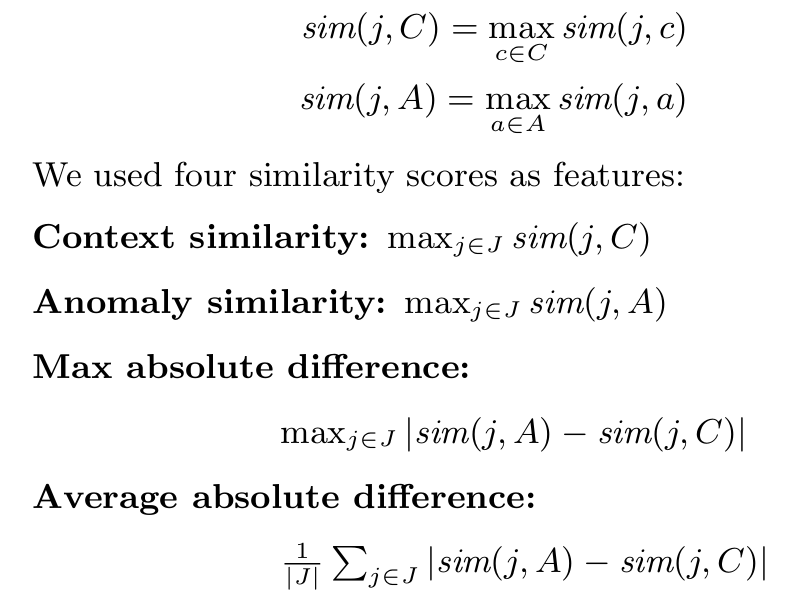

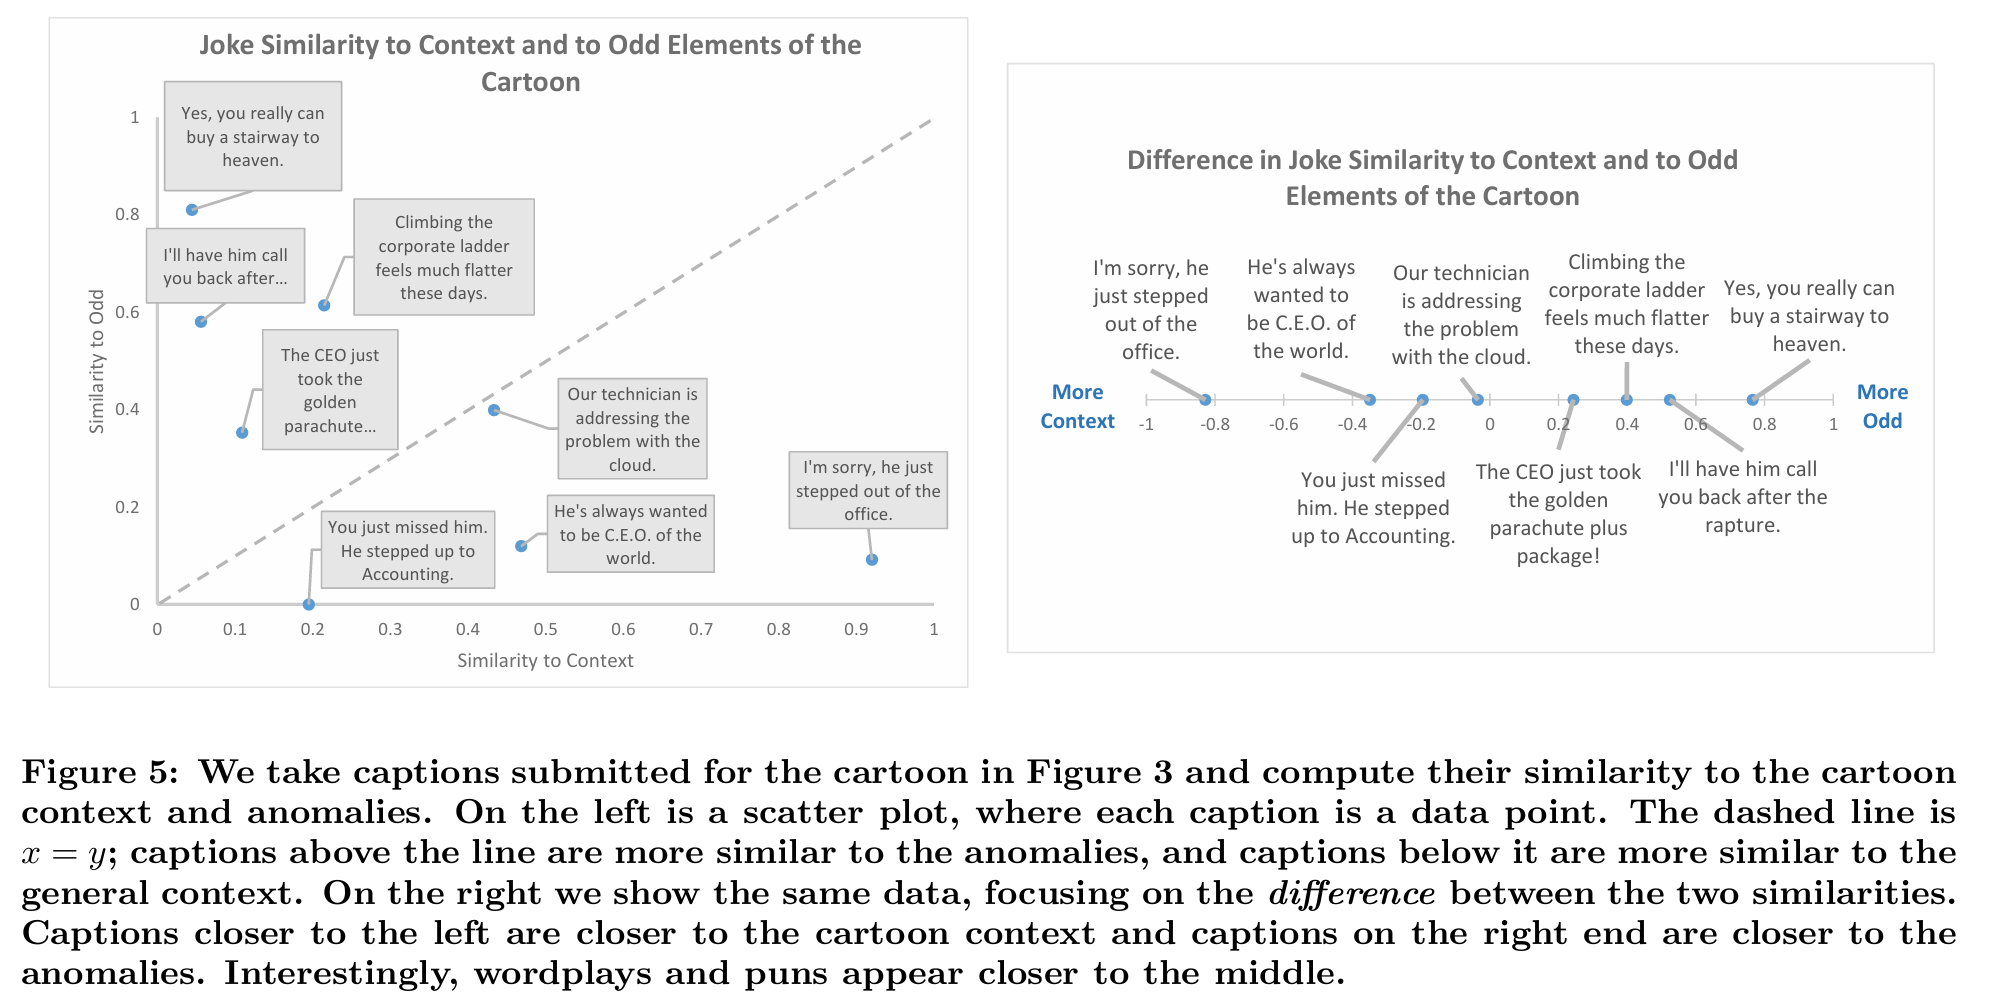